## Importação de Bibliotecas

In [2]:
# Bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Balanceamento
from imblearn.over_sampling import SMOTE, ADASYN

# Redução
from sklearn.decomposition import PCA

# Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Cluster (agrupamento)
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Classificação
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict

    # Árvore de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

    # KNN
from sklearn.neighbors import KNeighborsClassifier

    # SVM
from sklearn.svm import SVC

    # Rede neural (MLP)
from sklearn.neural_network import MLPClassifier

# Seleção e pré-processamento de dados:

* **Base de dados**: ["Loan Data Set"](https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download);
* **Problema a ser investigado**: Aprovação ou não aprovação de empréstimo para pessoas de acordo com seus dados;
* **Número de amostras**: 614;
* **Número de atributos**: 12;
* **Tipos de atributos**: Categóricos e numéricos;
* **Valores ausentes**: Sim.

### Limpeza de dados

* Leitura da base de dados

In [3]:
def ShowInformationDataFrame(df, message=""):
    print(message+"\n")
    # Imprime as 10 primeiras linhas do arquivo
    print("PRIMEIRAS 10 LINHAS\n")
    print(df.head(10))
    print("\n")
    # Imprime informações sobre os dados
    print("INFORMAÇÕES GERAIS DOS DADOS\n")
    print(df.info())
    print("\n")
    # Imprime uma analise descritiva sobre os dados
    print("DESCRIÇÃO DOS DADOS\n")
    print(df.describe())
    print("\n")
    # Imprime a quantidade de valores faltantes por coluna
    print("VALORES FALTANTES\n")
    print(df.isnull().sum())
    print("\n") 

In [4]:
input_file = './0-Datasets/loan_train.csv'
names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area']
target = 'Status'
df = pd.read_csv(input_file,        # Nome do arquivo com dados
                names = names,      # Nome das colunas 
                usecols = columns, # Define as colunas que serão  utilizadas
                na_values='')       # Define que ? será considerado valores ausentes

ShowInformationDataFrame(df, "DataFrame")

DataFrame

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History       Area Status  
0                 0.0     11500000  360.0 

* Tratamento dos valores faltantes
  * método de DELETAR os objetos que possuem valores faltantes

In [5]:
def UpdateMissingValues(df, column, method="mode", number=0):
    if method == 'number':
        # Substituindo valores ausentes por um número
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        # Substituindo valores ausentes pela mediana 
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        # Substituindo valores ausentes pela média
        mean = df[column].mean()
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        # Substituindo valores ausentes pela moda
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    elif method == 'delete':
        df.dropna(axis=0, how='any', subset=column, inplace=True)

columns_missing_value = df.columns[df.isnull().any()]
print(columns_missing_value)
method = 'delete' # number or median or mean or mode
    
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)
    
ShowInformationDataFrame(df,"Dataframe UpdateMissingValues")

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'Term',
       'Credit_History'],
      dtype='object')
Dataframe UpdateMissingValues

PRIMEIRAS 10 LINHAS

  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0  Not Graduate            No            604500   
1   Male      No          0      Graduate            No            584900   
2   Male     Yes          1      Graduate            No            458300   
3   Male     Yes          0      Graduate           Yes            300000   
4   Male     Yes          0  Not Graduate            No            258300   
5   Male      No          0      Graduate            No            600000   
6   Male     Yes          2      Graduate           Yes            541700   
7   Male     Yes          0  Not Graduate            No            233300   
8   Male     Yes         3+      Graduate            No            303600   
9   Male     Yes          2      Graduate            No        

* Conversão dos atributos categóricos para numéricos

In [6]:
# Converte os atributos categóricos para numéricos
    # get all categorical columns
cat_columns = df.select_dtypes(['object']).columns

    # convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

ShowInformationDataFrame(df,"Dataframe numérico")

Dataframe numérico

PRIMEIRAS 10 LINHAS

   Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
0       0        0           0          0              0            604500   
1       0        0           0          1              0            584900   
2       0        1           1          1              0            458300   
3       0        1           0          1              1            300000   
4       0        1           0          0              0            258300   
5       0        0           0          1              0            600000   
6       0        1           2          1              1            541700   
7       0        1           0          0              0            233300   
8       0        1           3          1              0            303600   
9       0        1           2          1              0            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     

### Balanceamento de dados

A base se apresentou desbalanceada, dessa forma, foi necessário utilizar uma técnica de balanceamento.

* Técnicas de Oversample:
  * SMOTE (utilizada)
  * ADASYN

Base default
 1    341
0    158
Name: Status, dtype: int64
Base balanceada
 0    341
1    341
Name: Status, dtype: int64


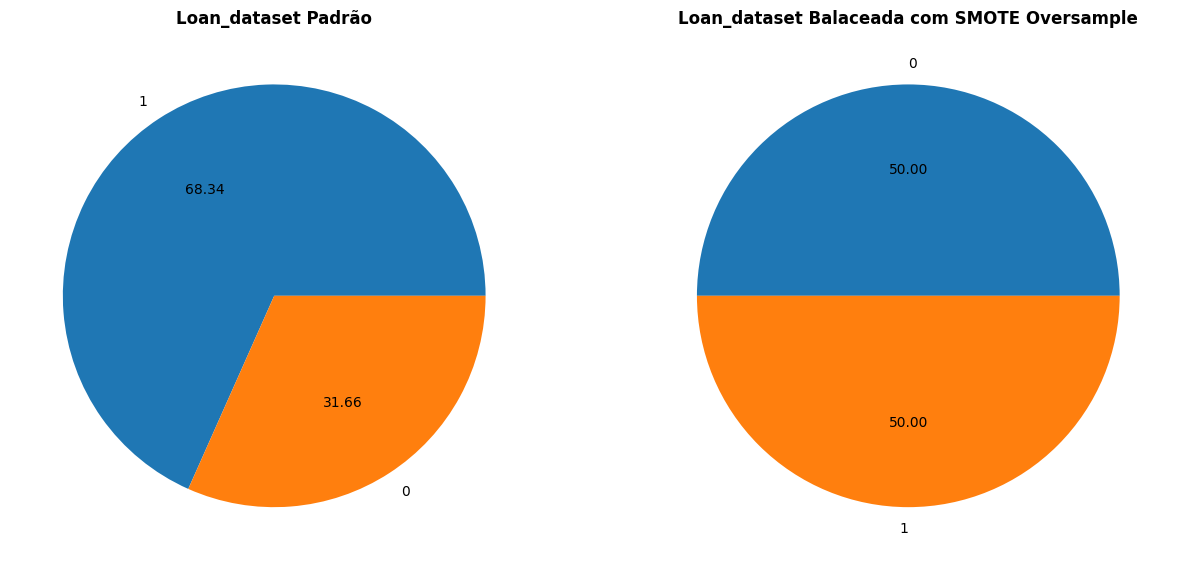

In [7]:
x = df.drop(['Status'], axis=1)
y = df['Status']

# Synthetic Minority Oversampling Technique (SMOTE)
x_os, y_os = SMOTE().fit_resample(x, y)
# Adaptive Synthetic (ADASYN) sampling method
# x_os, y_os = ADASYN().fit_resample(x, y)

print('Base default\n',y.value_counts())
print('Base balanceada\n',y_os.value_counts())

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

y.value_counts().plot.pie(ax=ax[0], autopct='%.2f')
y_os.value_counts().plot.pie(ax=ax[1], autopct='%.2f')

plt.subplots_adjust(hspace = 1)

for n in np.arange(0,2):
    ax[n].set_ylabel('')
    
ax[0].set_title('Loan_dataset Padrão', fontweight='bold')
ax[1].set_title('Loan_dataset Balaceada com SMOTE Oversample', fontweight='bold')

plt.show()

---
# Normalização e redução de dados

### Normalização de dados
* Max-Min
* Z-Score

In [8]:
# Z-score normalization
x_zscore = StandardScaler().fit_transform(x_os)
normalized_zscore_Df = pd.DataFrame(data = x_zscore, columns = features)
normalized_zscore_Df = pd.concat([normalized_zscore_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_zscore_Df,"Dataframe Z-Score Normalized")

# Mix-Max normalization
x_minmax = MinMaxScaler().fit_transform(x_os)
normalized_minmax_Df = pd.DataFrame(data = x_minmax, columns = features)
normalized_minmax_Df = pd.concat([normalized_minmax_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_minmax_Df,"Dataframe Min-Max Normalized")

Dataframe Z-Score Normalized

PRIMEIRAS 10 LINHAS

    Gender   Married  Dependents  Education  Self_Employed  Applicant_Income  \
0 -0.40475 -1.159156   -0.723321  -1.615074      -0.346221          0.120534   
1 -0.40475 -1.159156   -0.723321   0.619166      -0.346221          0.083169   
2 -0.40475  0.862697    0.324036   0.619166      -0.346221         -0.158183   
3 -0.40475  0.862697   -0.723321   0.619166       2.888333         -0.459968   
4 -0.40475  0.862697   -0.723321  -1.615074      -0.346221         -0.539465   
5 -0.40475 -1.159156   -0.723321   0.619166      -0.346221          0.111955   
6 -0.40475  0.862697    1.371393   0.619166       2.888333          0.000812   
7 -0.40475  0.862697   -0.723321  -1.615074      -0.346221         -0.587126   
8 -0.40475  0.862697    2.418750   0.619166      -0.346221         -0.453105   
9 -0.40475  0.862697    1.371393   0.619166      -0.346221         -0.268183   

   Coapplicant_Income  Loan_Amount      Term  Credit_History      Ar

### Redução de dados (PCA)

Explained variance per component:
[0.1659309103784025, 0.1399018445762776, 0.11511832923611966, 0.10605151665220607, 0.08781361439141218, 0.08493911342584753, 0.07984988275420066, 0.06972055379930647, 0.06427532993012283, 0.05255536633733002, 0.0338435385187744]



Dataframe PCA

PRIMEIRAS 10 LINHAS

   principal component 1  principal component 2  Status
0              -1.396759              -0.079949       0
1              -0.433606              -1.084185       1
2               0.440434               0.515782       0
3               0.050202               0.020046       1
4              -0.708540               0.916214       1
5              -0.477618              -1.067275       1
6               2.524098               0.361098       1
7              -0.961533               0.980060       1
8               1.091192               1.551887       0
9               0.949452               0.872979       1


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

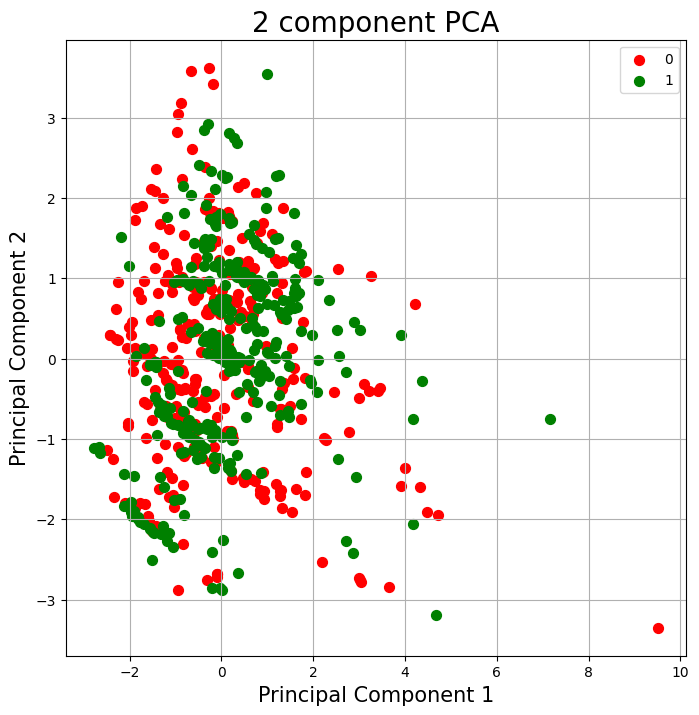

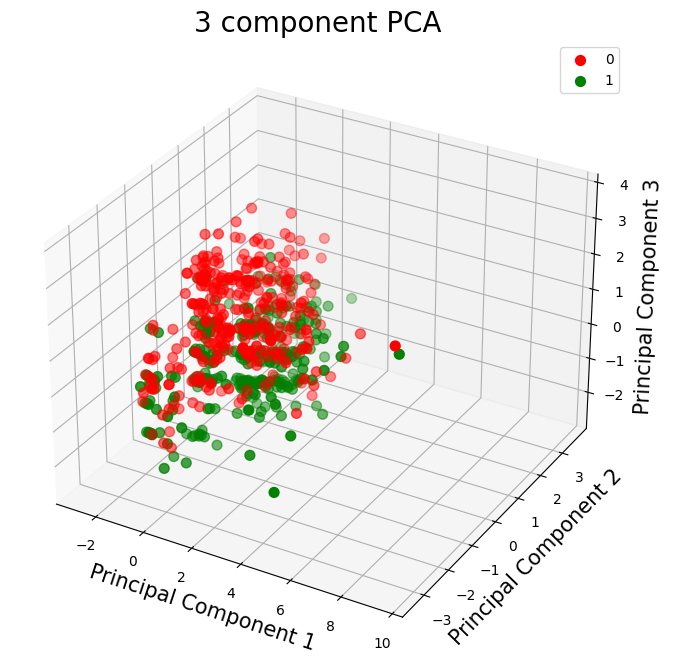

In [9]:
def VisualizePcaProjection(finalDf, targetColumn, tridimensional=False):
    fig = plt.figure(figsize = (8,8))
    
    if tridimensional:
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.set_zlabel('Principal Component 3', fontsize = 15)
        ax.set_title('3 component PCA', fontsize = 20)
    else:
        ax = fig.add_subplot(1,1,1)
        ax.set_title('2 component PCA', fontsize = 20)

    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)   
    
    targets = [ 0, 1 ]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[targetColumn] == target
        if tridimensional:
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   finalDf.loc[indicesToKeep, 'principal component 3'],
                   c = color, s = 50)
        else:
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                    finalDf.loc[indicesToKeep, 'principal component 2'],
                    c = color, s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

# PCA projection
pca = PCA()
# utilizando a normalização Z-Score    
principalComponents = pca.fit_transform(x_zscore)
# utilizando a normalização Max-Min  
# principalComponents = pca.fit_transform(x_minmax)
print("Explained variance per component:")
print(pca.explained_variance_ratio_.tolist())
print("\n\n")

principalDf = pd.DataFrame(data = principalComponents[:,0:2], 
                            columns = ['principal component 1', 
                                        'principal component 2'])
principalDf3d = pd.DataFrame(data = principalComponents[:,0:3], 
                            columns = ['principal component 1', 
                                        'principal component 2',
                                        'principal component 3'])
finalDf = pd.concat([principalDf, y_os], axis = 1)   
finalDf3d = pd.concat([principalDf3d, y_os], axis = 1)  
ShowInformationDataFrame(finalDf,"Dataframe PCA")

VisualizePcaProjection(finalDf, target)
VisualizePcaProjection(finalDf3d, target, tridimensional=True)

---
# Análise descritiva de dados
* Distribuição de frequência
* Visualização de dados (Histograma, Gráfico de setores, dispersão, etc)
* Medidas de resumo
  * Medidas de tendência central
  * Medidas de dispersão
  * Medidas de posição relativa
  * Medidas de associação

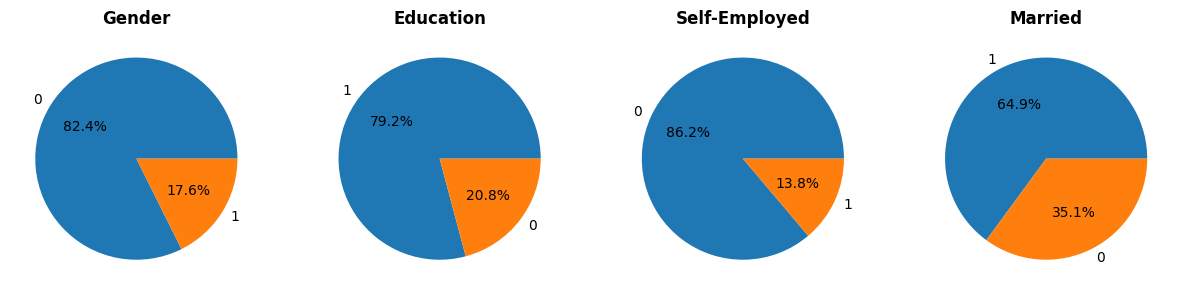

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15,10))
gender_pie = df['Gender'].value_counts()
married_pie = df['Married'].value_counts()
educ_pie = df['Education'].value_counts()
selfemp_pie = df['Self_Employed'].value_counts()

gender_pie.plot.pie(ax=ax[0], autopct='%1.1f%%')
educ_pie.plot.pie(ax=ax[1], autopct='%1.1f%%')
selfemp_pie.plot.pie(ax=ax[2], autopct='%1.1f%%')
married_pie.plot.pie(ax=ax[3],autopct='%1.1f%%' )

plt.subplots_adjust(hspace = 0.5)

for n in np.arange(0,4):
        ax[n].set_ylabel('')
        
ax[0].set_title('Gender', fontweight='bold')
ax[1].set_title('Education', fontweight='bold')
ax[2].set_title('Self-Employed', fontweight='bold')
ax[3].set_title('Married', fontweight='bold')

plt.show()

<AxesSubplot:>

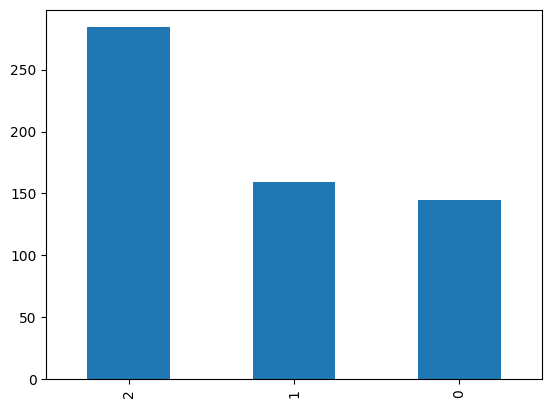

In [11]:
df['Dependents'].value_counts().plot.bar()
df['Area'].value_counts().plot.bar()

---
# Análise de grupos

In [12]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)
    plt.show()

### K-means
* Variar número de grupos (parâmetro k)

##### K-means Sklearn

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6639.489366658227
For n_clusters = 2, silhouette score is 0.13440260812878094)
For n_clusters = 2, homogeinity score is 0.030261705675633)


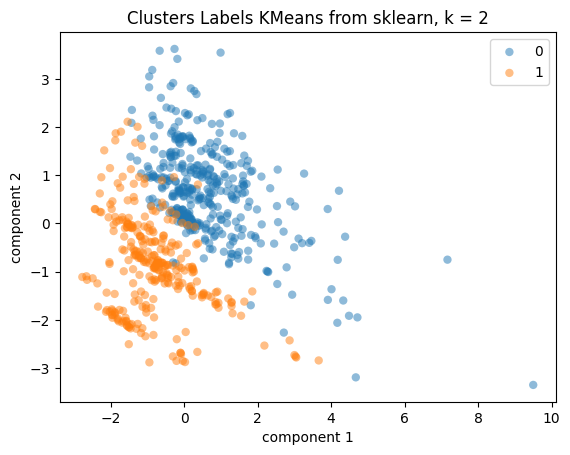

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6036.951249049262
For n_clusters = 3, silhouette score is 0.14290660055733306)
For n_clusters = 3, homogeinity score is 0.04061310363422945)


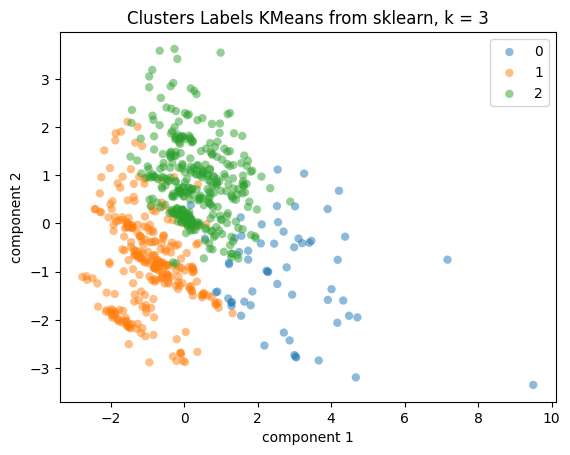

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5466.465306357478
For n_clusters = 4, silhouette score is 0.15629371173592008)
For n_clusters = 4, homogeinity score is 0.09644402826720441)


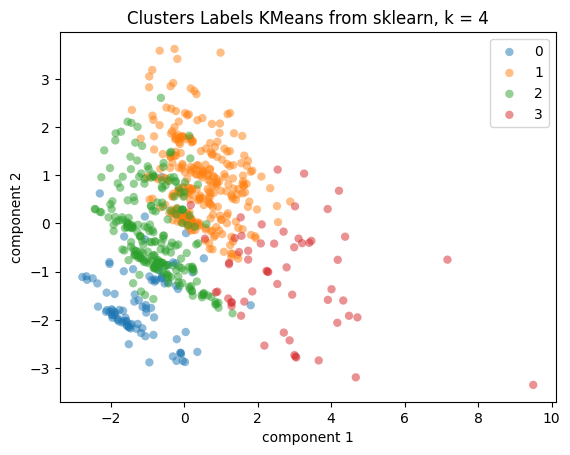

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4966.794331120839
For n_clusters = 5, silhouette score is 0.18570866366937466)
For n_clusters = 5, homogeinity score is 0.060887045296943325)


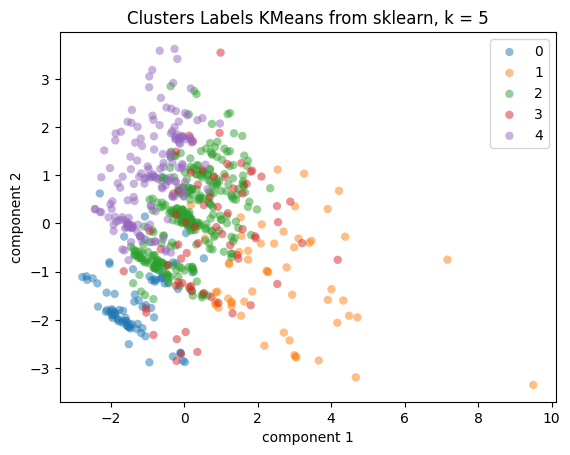

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4618.415453952067
For n_clusters = 6, silhouette score is 0.1918372405180173)
For n_clusters = 6, homogeinity score is 0.17579666713962988)


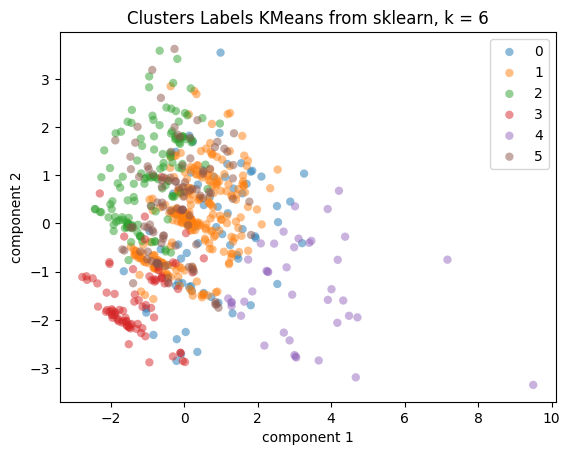

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4277.720971451594
For n_clusters = 7, silhouette score is 0.16893164402890481)
For n_clusters = 7, homogeinity score is 0.0746620658017757)


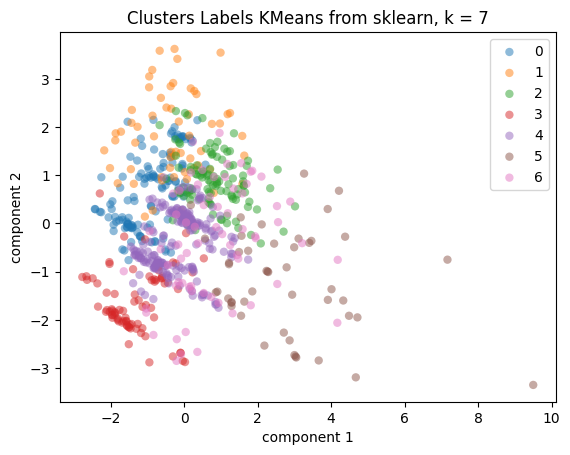

In [13]:
#Applying sklearn kmeans function
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k).fit(principalComponents)
    print(kmeans.inertia_)
    centers = kmeans.cluster_centers_
    score = silhouette_score(principalComponents, kmeans.labels_)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results sklearn
    plot_samples(principalComponents, kmeans.labels_, f'Clusters Labels KMeans from sklearn, k = {k}')

#### K-means implementado

For n_clusters = 2, silhouette score is 0.2704220419082982)
For n_clusters = 2, homogeinity score is 0.0013825970244505737)


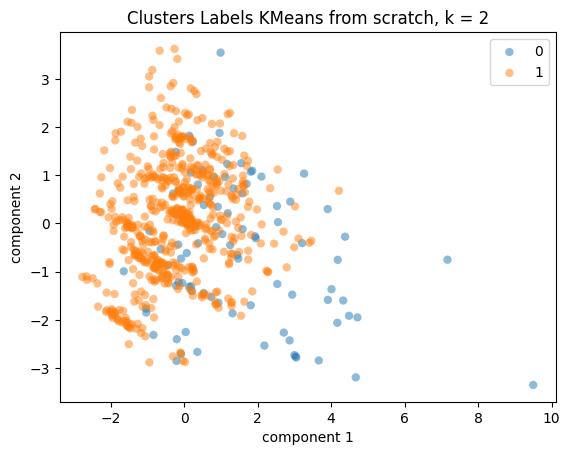

For n_clusters = 3, silhouette score is 0.1478789304037206)
For n_clusters = 3, homogeinity score is 0.021753816837835116)


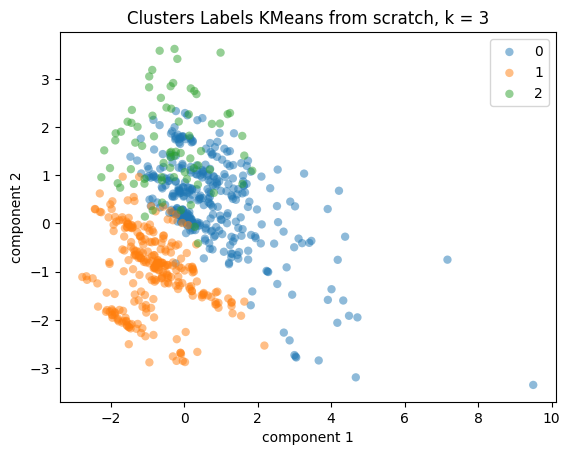

For n_clusters = 4, silhouette score is 0.1550912576727702)
For n_clusters = 4, homogeinity score is 0.0516935860033605)


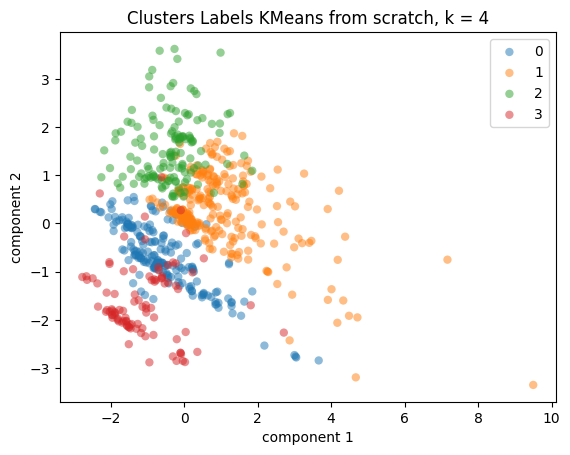

For n_clusters = 5, silhouette score is 0.16150797866140862)
For n_clusters = 5, homogeinity score is 0.04901500584262809)


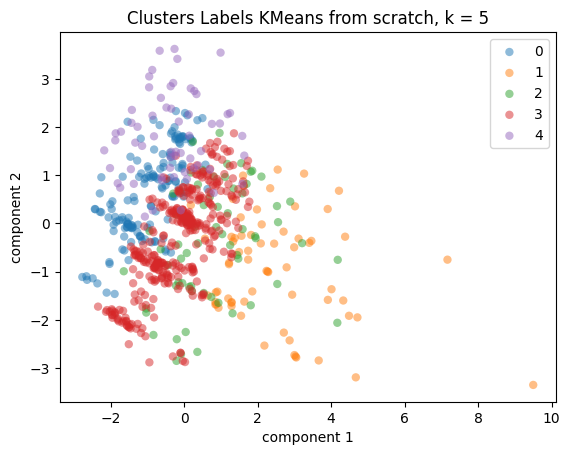

For n_clusters = 6, silhouette score is 0.15353654798843952)
For n_clusters = 6, homogeinity score is 0.19642008029868702)


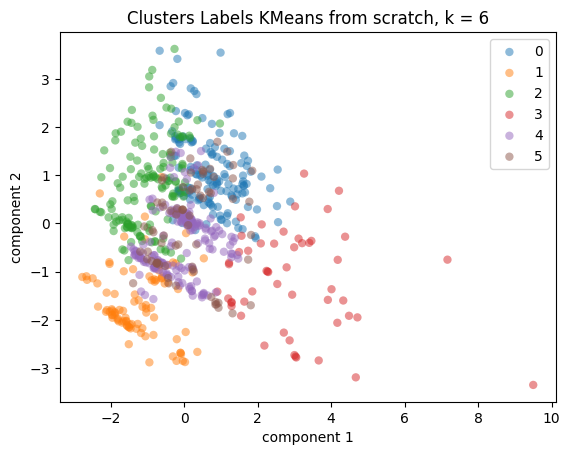

For n_clusters = 7, silhouette score is 0.15001176720639603)
For n_clusters = 7, homogeinity score is 0.10904702790389004)


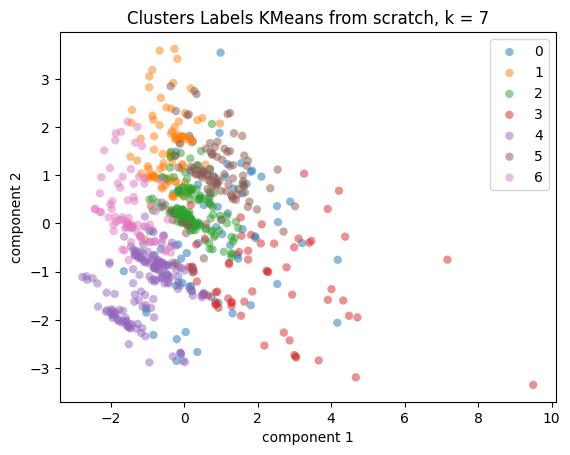

In [14]:
#Defining our kmeans function from scratch
def KMeans_scratch(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distance_type = ('euclidean', 'cityblock', 'minkowski', 'mahalanobis')
    dtype = 2
    distances = cdist(x, centroids ,distance_type[dtype]) #Step 2
    # Euclidean, Cityblock, Minkowski, Mahalanobis
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,distance_type[dtype])
        points = np.array([np.argmin(i) for i in distances])
         
    return points

for k in range(2, 8):
    #Applying our kmeans function from scratch
    labels = KMeans_scratch(principalComponents,k,25)

    score = silhouette_score(principalComponents, labels)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), labels)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results 
    plot_samples(principalComponents, labels, f'Clusters Labels KMeans from scratch, k = {k}')

### GMM

[0.14076246 0.85923754]
[[-1.06319009 -1.6279608  -0.94501164 -0.60039905  0.24508751  0.39058813
   0.33667995 -0.6227766   1.05590479 -0.41726307  0.06138974]
 [ 0.17417449  0.26669665  0.15481419  0.09835889 -0.04015085 -0.06398713
  -0.05515576  0.10202484 -0.17298099  0.06835709 -0.01005702]]
For k = 2
Silhouette score is 0.18787438091495093
Homogeinity score is 0.0025209811435672005


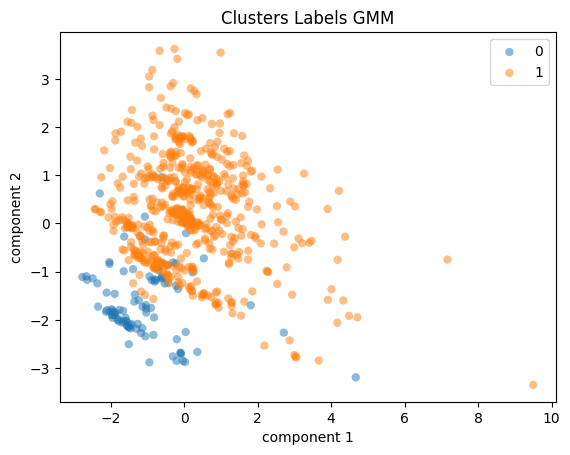

[0.31390304 0.54533449 0.14076246]
[[-0.63406311  0.97596089  0.56198727 -0.25087182  0.21859198 -0.22823326
   0.14234816  0.49562094  0.18740495 -0.08877396 -0.01655333]
 [ 0.63940866 -0.14156692 -0.07956098  0.29938154 -0.18908727  0.0305555
  -0.1688421  -0.12453523 -0.38042476  0.15880417 -0.00631765]
 [-1.06319009 -1.6279608  -0.94501164 -0.60039905  0.24508751  0.39058813
   0.33667995 -0.6227766   1.05590479 -0.41726307  0.06138974]]
For k = 3
Silhouette score is 0.15322319387378416
Homogeinity score is 0.02884730966647236


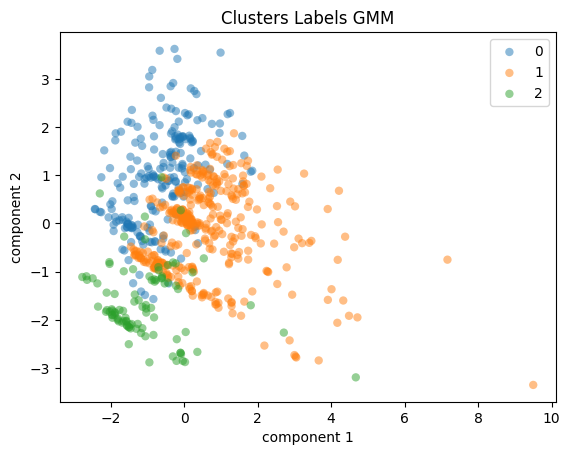

[0.13782981 0.58044548 0.25366569 0.02805901]
[[-1.16432861 -1.60453614 -0.93671308 -0.5813335   0.24410554  0.39308483
   0.32352563 -0.65048535  1.03819084 -0.39392691  0.10334202]
 [ 0.47903776 -0.01238961 -0.12214568  0.22424171 -0.12174768 -0.04389522
  -0.0880028  -0.22589836 -0.46621065  0.13603768 -0.09602037]
 [-0.80706754  1.00873526  0.76878654 -0.29624943  0.01044617 -0.1638872
  -0.02704347  0.78238322  0.41704062 -0.14950676 -0.00566833]
 [ 3.10592636 -0.98139991  0.17787964  0.89501773  1.22502637  0.45876636
   0.47575967  0.79525885  0.77434356  0.47247395  1.52994812]]
For k = 4
Silhouette score is 0.16972051557255866
Homogeinity score is 0.03852630688510677


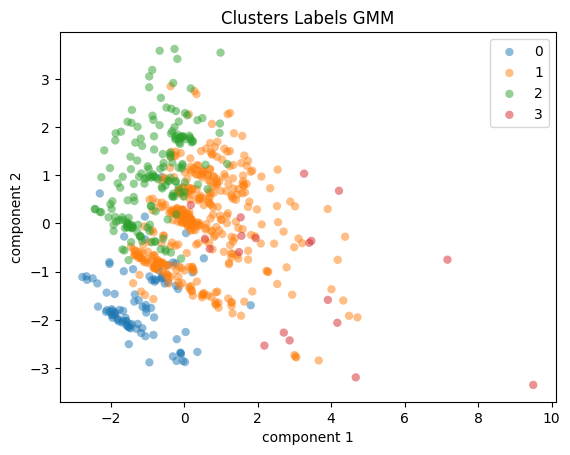

[0.31674228 0.37095593 0.03697648 0.09349025 0.18183506]
[[ 6.64756577e-01  2.22661695e-01 -5.21298840e-01  4.96859157e-01
  -5.59187330e-01  1.33339536e-01  2.64531303e-02 -2.61950571e-01
  -2.01744417e-01 -2.95019412e-01  1.00217172e-03]
 [-9.34585070e-01 -7.39396638e-01  4.30445467e-01  4.31404902e-02
   2.13589011e-02 -4.88375497e-02  2.26942511e-01  4.62938872e-02
   3.43679305e-02  4.70414765e-01 -9.95103760e-02]
 [ 3.00187562e+00 -1.12558152e+00  4.29455354e-01  1.95619729e-01
   9.08155335e-01 -1.79954558e-01  2.47707437e-03  4.83714087e-01
   6.18065297e-01  4.27995630e-01  9.80814939e-01]
 [ 6.00474380e-01 -2.72836679e-01 -5.43319555e-01 -1.66063010e+00
   1.39151647e+00 -1.28298194e-01 -1.73335441e+00  1.13035301e-01
  -2.76214011e-01 -3.81373785e-02 -1.22533901e-01]
 [-1.70505901e-01  1.48972814e+00  2.21939689e-01 -1.39467762e-01
   3.03651206e-02 -3.00765584e-02  3.81640635e-01  2.05373394e-01
   2.97640250e-01 -5.13203142e-01  6.48124162e-02]]
For k = 5
Silhouette score 

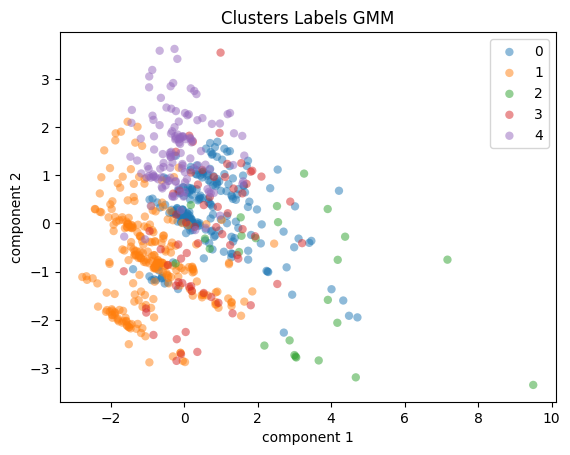

[0.24484813 0.09544067 0.2037673  0.0364392  0.12624788 0.29325681]
[[-0.84173671 -0.86801638 -0.09079887  0.24374946  0.09016657 -0.53876659
   0.33763593  0.0504616   0.05177813  0.13001424 -0.05012171]
 [ 0.63200716 -0.2595254  -0.54475999 -1.64650635  1.38076684 -0.13484604
  -1.74527809  0.10175461 -0.26533966 -0.03226179 -0.12135875]
 [-0.22229515 -0.13837904  0.77853611 -0.10312873 -0.22075952  0.94719141
   0.11696132 -0.15631365  0.01267523  0.04934885 -0.09597355]
 [ 2.81385539 -0.90090921 -0.00352432  0.33451282  0.95221942  0.27160095
   0.09655296  0.40008808  0.86950407  0.38415821  1.18788483]
 [-0.43482443  1.13888889  0.54212472 -0.29260226  0.39744561  0.05640368
   0.6352923  -0.10723757  0.05792608  0.11239522 -0.04555581]
 [ 0.48911385  0.5269944  -0.52080523  0.48840252 -0.6606825  -0.2224624
  -0.08066148  0.02981782 -0.09866254 -0.2284633   0.02003972]]
For k = 6
Silhouette score is 0.1022378096397758
Homogeinity score is 0.20046366595213266


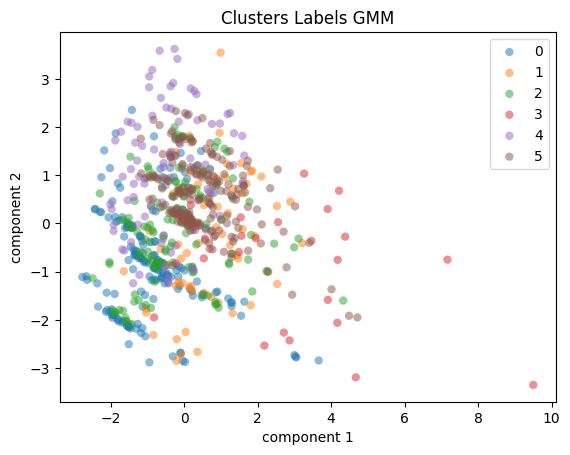

[0.18035191 0.23607038 0.1202346  0.09542784 0.02040793 0.33724341
 0.01026393]
[[-1.95489666e-01 -8.92921826e-01  5.79508726e-01  4.19811805e-01
  -7.36080603e-02 -8.03307393e-02  1.45863831e-01 -7.59793465e-02
  -5.92661659e-01  7.70692120e-01 -2.05578753e-01]
 [-8.72690192e-01  1.01796357e+00  7.96450525e-01 -2.06866708e-01
  -1.16297012e-01 -1.48384690e-01  9.46319313e-02  7.68659870e-01
   4.13994093e-01 -1.61893682e-01  4.57201049e-03]
 [-1.29162050e+00 -1.55085268e+00 -9.13036141e-01 -3.16148635e-01
   4.94525751e-02  4.06086626e-01  5.53934082e-01 -7.47244116e-01
   1.05921152e+00 -3.74624948e-01  8.14952198e-02]
 [ 6.32586413e-01 -2.57481635e-01 -5.45444701e-01 -1.64408343e+00
   1.38175717e+00 -1.33326682e-01 -1.74640226e+00  1.00969802e-01
  -2.62748587e-01 -3.06444507e-02 -1.23676612e-01]
 [ 3.91156952e+00 -1.41816533e+00  1.63589872e-01 -1.77444357e+00
   2.50005311e-01 -2.91654083e-01  6.28664663e-01  8.00976574e-01
   1.72802137e-01 -1.43809456e-02  1.25777530e+00]
 [ 7.

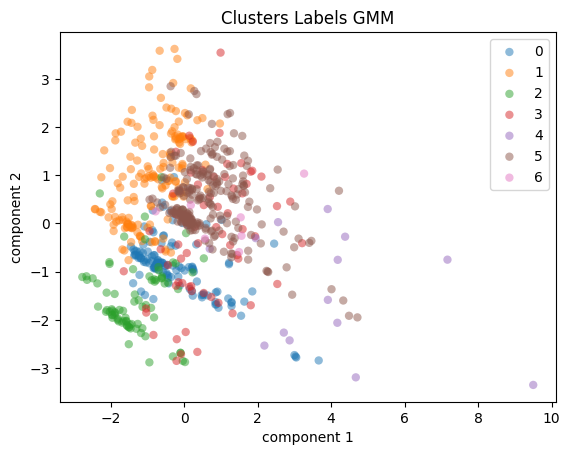

In [15]:
for k in range(2, 8):
    #Applying sklearn GMM function
    gm  = GaussianMixture(n_components=k).fit(principalComponents)
    print(gm.weights_)
    print(gm.means_)
    gm_predicts = gm.predict(principalComponents)
    silhouette_gm_score = silhouette_score(principalComponents, gm_predicts)
    homogeneity_gm_score = homogeneity_score(y_os.to_numpy(), gm_predicts)
    print("For k =", k)
    print("Silhouette score is {}".format(silhouette_gm_score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("Homogeinity score is {}".format(homogeneity_gm_score))
    #Visualize the results sklearn
    plot_samples(principalComponents, gm_predicts, 'Clusters Labels GMM')

---
# Classificação
* Divisão da base:
  * Holdout (Treinamento 70% e Teste 30%)
  * Cross-Validation (k=10)
* Métricas:
  * Matrix de confusão
  * Acurácia
  * F1 Score

In [16]:
x_use = x_zscore # ou x_minmax ou x_zscore ou principalComponents
y_use = y_os

# Separação de conjunto de treinamento (70%) e teste (30%)
x_train, x_test, y_train, y_test = train_test_split(x_use, y_use, test_size=0.3, random_state=0)
print(x_train.shape)
print(x_test.shape)

acuracia_holdout = dict()
f1_holdout = dict()
acuracia_crossval = dict()
f1_crossval = dict()

(477, 11)
(205, 11)


### Árvore de Decisão (Decision Tree)

* Holdout

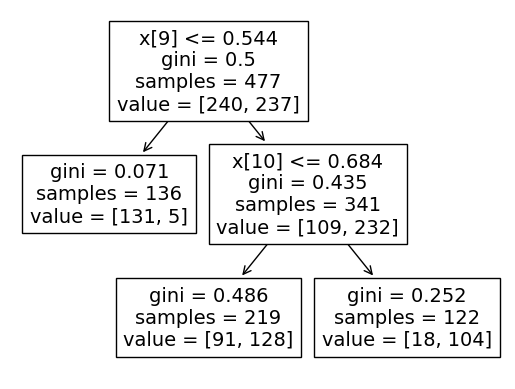

accuracy_score = 75.61%
f1_score = 80.31%


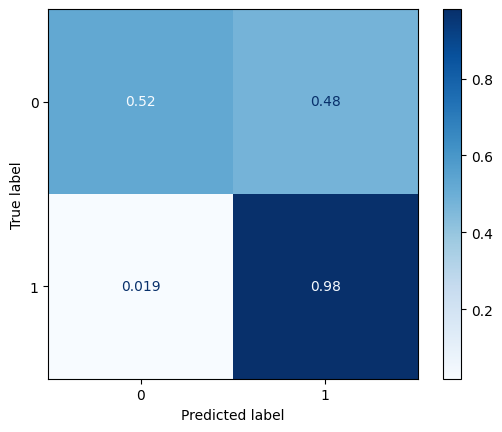

In [17]:
# Construindo a Árvore de decisão
clf = DecisionTreeClassifier(max_leaf_nodes=3)
clf.fit(x_train, y_train)
tree.plot_tree(clf)
plt.show()

predictions = clf.predict(x_test)
# print(predictions)

# Métricas
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['DecisionTree'] = accuracy
f1_holdout['DecisionTree'] = f1_score

* Cross-Validation

accuracy_score = 75.83%
f1_score = 80.41%


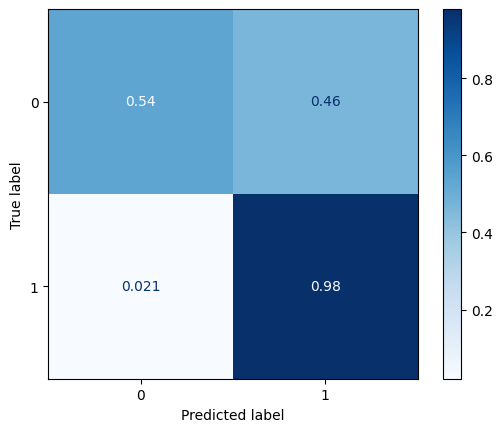

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = DecisionTreeClassifier(max_leaf_nodes=3)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['DecisionTree'] = accuracy
f1_crossval['DecisionTree'] = f1_score

### KNN (K-Mearest Neighbors)
* Encontrar o parâmetro k com melhor resultado

* Holdout

Best K: 9
Best Accuracy: 0.8
Acurracy K-NN: 80.00%
F1 Score K-NN: 81.78%


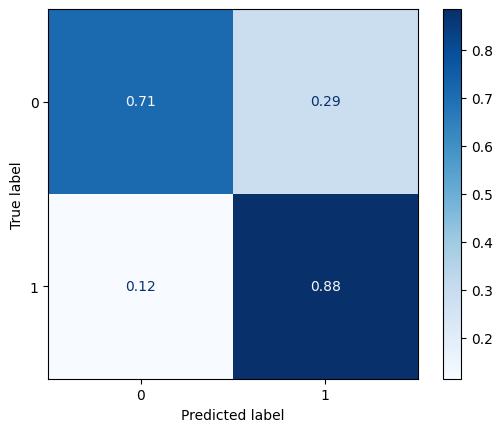

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_k = 0
best_accuracy = 0
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_hat_test = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_hat_test)
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# TESTS USING knn classifier from sk-learn
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)
y_hat_test = knn.predict(x_test)

# Get test accuracy and F1 score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy K-NN: {:.2f}%".format(accuracy * 100))
print("F1 Score K-NN: {:.2f}%".format(f1_score * 100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['KNN'] = accuracy
f1_holdout['KNN'] = f1_score

* Cross-Validation

Best K: 12
Best Accuracy: 0.7845694799658993
accuracy_score = 78.46%
f1_score = 80.22%


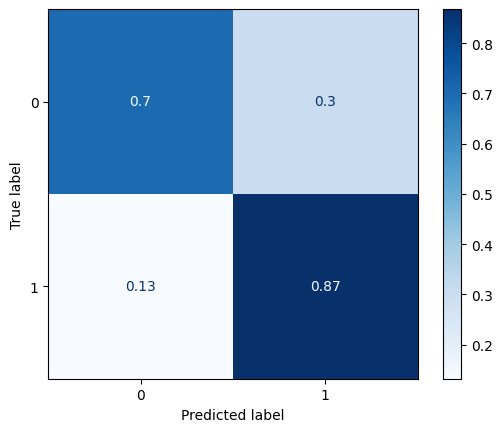

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


best_k = 0
best_accuracy = 0
for k in range(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k)
    result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)
    accuracy = result['test_accuracy'].mean()
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# Validação-cruzada
clf = KNeighborsClassifier(n_neighbors=best_k)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
#print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['KNN'] = accuracy
f1_crossval['KNN'] = f1_score

### SVM (Support Vectors Machine)

* Holdout

Qtd Support vectors: 
[121 121]
Acurracy SVM from sk-learn: 76.10%
F1 Score SVM from sk-learn: 78.60%


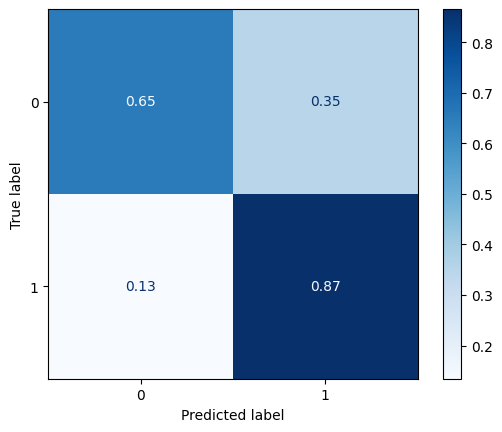

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

 # TESTS USING SVM classifier from sk-learn    
svm = SVC(kernel='linear') # poly, rbf, linear
# training using train dataset
svm.fit(x_train, y_train)
# get support vectors
# print(svm.support_vectors_)
# get indices of support vectors
# print(svm.support_)
# get number of support vectors for each class
print("Qtd Support vectors: ")
print(svm.n_support_)
# predict using test dataset
y_hat_test = svm.predict(x_test)

# Get test accuracy score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy SVM from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score SVM from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['SVM'] = accuracy
f1_holdout['SVM'] = f1_score

* Cross-Validation

accuracy_score = 77.59%
f1_score = 79.66%


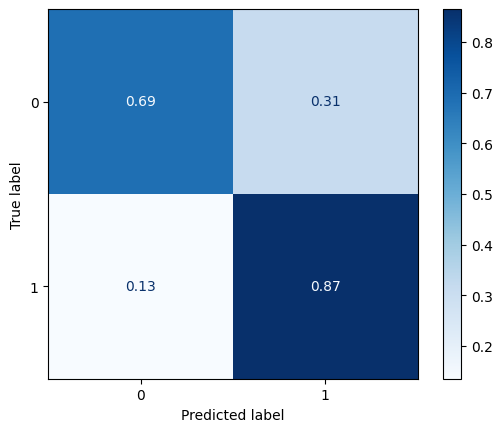

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = SVC(kernel='linear') # poly, rbf, linear
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score = {:.2f}%'.format(accuracy*100) )
print('f1_score = {:.2f}%'.format(f1_score*100) )
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['SVM'] = accuracy
f1_crossval['SVM'] = f1_score

### Rede Neural MLP (Multilayer Perceptron)
* Arquitetura da rede:
  * Número de neurônios
  * Camadas escondidas
  * Tipo de função de ativação

* Holdout

Acurracy MLP from sk-learn: 76.59%
F1 Score MLP from sk-learn: 77.57%


c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


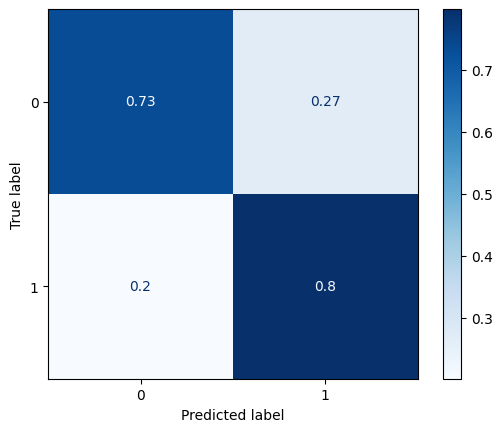

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(10,10),
                    activation='relu',
                    max_iter=1500)
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_test)
# print(predictions)

# Get test accuracy score
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['MLP'] = accuracy
f1_holdout['MLP'] = f1_score

* Cross-Validation

Acurracy MLP from sk-learn: 77.88%
F1 Score MLP from sk-learn: 79.48%


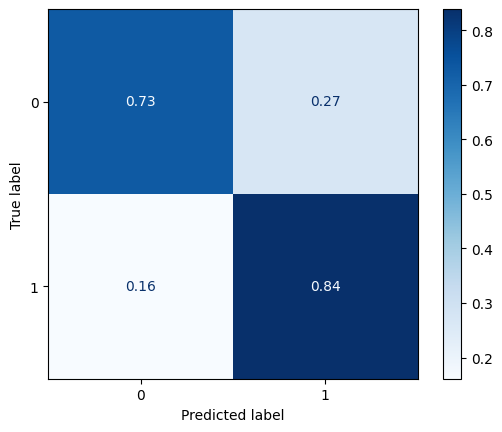

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf = MLPClassifier(hidden_layer_sizes=(10,10),
                    activation='relu',
                    max_iter=1500)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
# print(predictions)
# Get test accuracy score
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['MLP'] = accuracy
f1_crossval['MLP'] = f1_score

### Comparação final dos classificadores

In [25]:
tree_metrics_holdout = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_holdout['DecisionTree'], 'f1_score': f1_holdout['DecisionTree']})
knn_metrics_holdout = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_holdout['KNN'], 'f1_score': f1_holdout['KNN']})
svm_metrics_holdout = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_holdout['SVM'], 'f1_score': f1_holdout['SVM']})
mlp_metrics_holdout = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_holdout['MLP'], 'f1_score': f1_holdout['MLP']})

tree_metrics_cross_val = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_crossval['DecisionTree'], 'f1_score': f1_crossval['DecisionTree']})
knn_metrics_cross_val = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_crossval['KNN'], 'f1_score': f1_crossval['KNN']})
svm_metrics_cross_val = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_crossval['SVM'], 'f1_score': f1_crossval['SVM']})
mlp_metrics_cross_val = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_crossval['MLP'], 'f1_score': f1_crossval['MLP']})

df_metrics_holdout = pd.DataFrame([tree_metrics_holdout, knn_metrics_holdout, svm_metrics_holdout, mlp_metrics_holdout])
df_metrics_cross_val = pd.DataFrame([tree_metrics_cross_val, knn_metrics_cross_val, svm_metrics_cross_val, mlp_metrics_cross_val])

print('\nHOLDOUT\n', df_metrics_holdout.head())
print('\nCROSS-VALIDATION\n', df_metrics_cross_val.head())


HOLDOUT
   Classificador  accuracy  f1_score
0  DecisionTree  0.756098  0.803150
1           KNN  0.800000  0.817778
2           SVM  0.760976  0.786026
3           MLP  0.765854  0.775701

CROSS-VALIDATION
   Classificador  accuracy  f1_score
0  DecisionTree  0.758269  0.804103
1           KNN  0.784569  0.802221
2           SVM  0.775895  0.796593
3           MLP  0.778815  0.794806
